# Skeleton Threat Detection

In [1]:
import time
import numpy as np
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

# Part 1: Load Data

In [2]:
# set relevant skeletal indexes in the desired order with labels. Create array for skeletons with confidence flag
rele_dexes = [6,8,10,12,5,7,9,11,0,-1]
joint_names = ['R Shoulder','R Elbow','R Wrist','R Hip','L Shoulder','L Elbow','L Wrist','L Hip','Chest','Gun']
conf_flag = 1   # should be 0 or 1
x = np.empty((1,len(rele_dexes),2+conf_flag))
y = []

# set indexes for normalization 
right_elbow = 8
right_wrist = 10
l_shoulder = 5
r_shoulder = 6

#set folders and labels for each folder (0=high,1=medium,2=low)
folders = ["body_coco/skeleton_threat/1_high/skeletons/", "body_coco/skeleton_threat/2_medium/skeletons/", "body_coco/skeleton_threat/3_mild/skeletons/", "body_coco/skeleton_threat/4_low/skeletons/"]
threats = [0,1,2,2]

#read skeletons into array and create labels
last_count = 0
for folder in range(len(folders)):
    for f in listdir(folders[folder]):
        skele = np.load(folders[folder]+f)    #read skeletons
        skele[-1][-1] = 1  #reset gun confidence which is always 0 in given files
        if skele[rele_dexes].all() > .0001:     #only include skeletons with all joints
            skele[:,0:2] -= skele[right_elbow,0:2]     #normalize to right elbow with elbow to wrist=1
            forearm_len = np.sqrt(skele[right_wrist][0]**2+skele[right_wrist][1]**2)
            skele[:,0:2] /= forearm_len
            skele[0] = (skele[l_shoulder] + skele[r_shoulder])/2   #calculate chest index for skeletal comparison
            x = np.vstack((x,np.expand_dims(skele[rele_dexes,0:2+conf_flag],axis=0))) #add to input array
    y = np.concatenate((y,[threats[folder]]*(x.shape[0]-last_count)))   #add labels to label list
    last_count = x.shape[0]
                    
x_flat = x.reshape([x.shape[0],x.shape[1]*x.shape[2]]) #flatten for neural network input

#checks for sizes
print(x.shape)
print(y.shape)
print(x[-1])

(1471, 10, 3)
(1471,)
[[ 0.93254202  0.48161385  4.37526408]
 [ 0.          0.          5.4692235 ]
 [-0.78673816 -0.61728686  5.24052811]
 [ 1.14912533  3.6012014   2.63764807]
 [ 2.21164281  0.45873213  4.46244648]
 [ 2.44494012  2.42331951  4.92402482]
 [ 1.63649646  3.61879279  4.14439843]
 [ 2.26786108  3.6105473   2.91979881]
 [ 1.57209242  0.47017299  4.41885528]
 [ 1.46756926  3.01078641  1.        ]]


In [3]:
# create one hot label array from labels
oh_y = np.array(y,dtype=np.int64)
num_labels = len(np.unique(oh_y))
oh_y = np.eye(num_labels)[oh_y]

# columns: x, y, confidence

# Create and Train Model

In [4]:
from feedforward_model import *

In [5]:
# set splits for k-folds and create empty array
splits = 10
kf = KFold(n_splits=splits, shuffle=True, random_state=1)
conf_mat = np.empty((splits,num_labels,num_labels))

# train models for each split and save to an array
i = 0
for train_index, test_index in kf.split(x_flat):
    x_train, x_test = x_flat[train_index], x_flat[test_index]   #create train and test sets
    y_train, y_test = oh_y[train_index], oh_y[test_index]
    
    # create and train model
    model = feedforward(x_flat.shape[1],num_labels,hidden_layer_size=[8],learning_rate=.0025,train_keep_prob=[.5])
    model.train(x_train,y_train,x_test,y_test,epochs=30,batch_size=64)
    conf_mat[i] = confusion_matrix(y[test_index],model.predict(x_test)[0])  #add confusion matrix to array
    i += 1

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

number of batches for training: 20
0.024487733840942383
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 22.972972972972975%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.02702702702703%
epoch 4
Best validation accuracy! iteration:75 accuracy: 65.54054054054053%
epoch 5
Best validation accuracy! iteration:100 accuracy: 67.56756756756756%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 70.27027027027027%
epoch 8
Best validation accuracy! iteration:150 accuracy: 70.94594594594594%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch

epoch 10
Best validation accuracy! iteration:200 accuracy: 80.95238095238095%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 82.31292517006803%
epoch 13
Best validation accuracy! iteration:250 accuracy: 83.6734693877551%
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 84.35374149659864%
epoch 23
Best validation accuracy! iteration:450 accuracy: 85.03401360544217%
epoch 24
Best validation accuracy! iteration:475 accuracy: 85.71428571428571%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.71428571428571. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.018051862716674805
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.97959183673469%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 58.50340136054422%
epoch 5
Best validation accur

[[654.  28.  10.]
 [ 70. 161.  94.]
 [ 11.  26. 417.]]
mean
[[65.4  2.8  1. ]
 [ 7.  16.1  9.4]
 [ 1.1  2.6 41.7]]
std
[[3.55527777 1.4        1.4832397 ]
 [2.56904652 4.18210473 3.13687743]
 [1.04403065 1.8        6.13269924]]
83.75254928619987
0.55951266739775
8.230431337420901


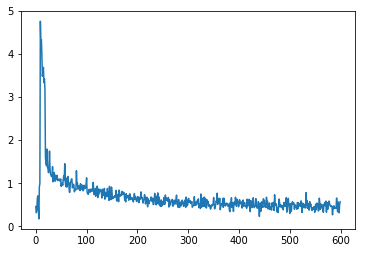

In [6]:
# plot loss, total classifications, mean over splits, and std over splits
model.plot()
print(sum(conf_mat))
print("mean")
print(np.mean(conf_mat,axis=0))
print("std")
print(np.std(conf_mat,axis=0))

#create accuracy (sum of diagonal dividied by total classified)
mat = sum(conf_mat)
diag = sum(np.diagonal(mat))
print(diag/sum(sum(mat))*100)

#find and print standard deviations
stds = np.std(conf_mat,axis=0)
var = 0
for i in range(conf_mat.shape[1]):
    var += stds[i,i]**2
print(np.sqrt(var)/sum(sum(mat))*100)
print(np.sqrt(var))

In [7]:
#give a prediction example
labels = np.array(['High','Med','Low'])
test = np.reshape(x_test[0],(1,len(x_test[0])))
prediction = model.predict(test)
print("Predicted label is ", labels[prediction[0][0]])
tested_y = np.ndarray.astype(y_test[0],bool)
print("Actual label is ",labels[tested_y][0])

INFO:tensorflow:Restoring parameters from model/basic_model
Predicted label is  High
Actual label is  High


In [8]:
# find and print mean and totals in LaTeX code
mean = np.mean(conf_mat,axis=0)
totals_b = np.sum(mean,axis=0)
totals_r = np.sum(mean,axis=1)
total = np.sum(totals_r)
print(end='\\rota{Actual}')
for i in range(mean.shape[0]):
    print(" & {0:s} & {1:.1f} & {2:.1f} & {3:.1f} & {4:.1f} \\\\".format(labels[i],mean[i,0],mean[i,1],mean[i,2],totals_r[i]))
print('\\toprule')
print(" & Totals & {0:.1f} & {1:.1f} & {2:.1f} & {3:.1f}".format(totals_b[0],totals_b[1],totals_b[2],total))

\rota{Actual} & High & 65.4 & 2.8 & 1.0 & 69.2 \\
 & Med & 7.0 & 16.1 & 9.4 & 32.5 \\
 & Low & 1.1 & 2.6 & 41.7 & 45.4 \\
\toprule
 & Totals & 73.5 & 21.5 & 52.1 & 147.1


In [9]:
#create new confusion matrix
conf_mat = np.empty((x.shape[1],splits,num_labels,num_labels))

#remove each joint from input and retrain with k-folds
for i in range(x.shape[1]):
    print(i)
    sub_x = np.delete(x,i,1)
    sub_x = sub_x.reshape([sub_x.shape[0],sub_x.shape[1]*sub_x.shape[2]])
    j = 0
    for train_index, test_index in kf.split(sub_x):
        x_train, x_test = sub_x[train_index], sub_x[test_index]
        y_train, y_test = oh_y[train_index], oh_y[test_index]
        model = feedforward(sub_x.shape[1],num_labels,hidden_layer_size=[8],learning_rate=.0025,train_keep_prob=[.5])
        model.train(x_train,y_train,x_test,y_test,epochs=30,batch_size=64)
        conf_mat[i,j] = confusion_matrix(y[test_index],model.predict(x_test)[0])
        j += 1

0
number of batches for training: 20
0.018508195877075195
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.32432432432432%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 53.37837837837838%
epoch 5
Best validation accuracy! iteration:100 accuracy: 64.86486486486487%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 68.24324324324324%
epoch 8
Best validation accuracy! iteration:150 accuracy: 72.97297297297297%
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 73.64864864864865%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 74.32432432432432%
epoch 13
Best validation accuracy! iteration:250 accuracy: 75.0%
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 76.35135135135135%
epoch 18
Best validation accuracy! iteration:350 accuracy: 78.37837837837837%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 79.7297297

number of batches for training: 20
0.02376699447631836
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.97959183673469%
epoch 3
Best validation accuracy! iteration:50 accuracy: 57.14285714285714%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 62.585034013605444%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 71.42857142857143%
epoch 8
epoch 9
Best validation accuracy! iteration:175 accuracy: 72.78911564625851%
epoch 10
Best validation accuracy! iteration:200 accuracy: 74.14965986394559%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 76.19047619047619%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 79.59183673469387%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 81.63265306122449%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.63265306122449. Mode

epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 82.99319727891157%
Traning ends. The best valid accuracy is 82.99319727891157. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.017142295837402344
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 25.170068027210885%
epoch 3
Best validation accuracy! iteration:50 accuracy: 46.93877551020408%
epoch 4
Best validation accuracy! iteration:75 accuracy: 49.65986394557823%
epoch 5
Best validation accuracy! iteration:100 accuracy: 55.10204081632652%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 65.98639455782312%
epoch 8
Best validation accuracy! iteration:150 accuracy: 71.42857142857143%
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.82993197278913%
epoch 10
Best validation accuracy! iteration:200 accuracy: 75.51020408163265%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 76.8

epoch 12
Best validation accuracy! iteration:225 accuracy: 80.95238095238095%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 82.99319727891157%
epoch 18
Best validation accuracy! iteration:350 accuracy: 83.6734693877551%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 84.35374149659864%
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 85.03401360544217%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.03401360544217. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.016878128051757812
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 28.57142857142857%
epoch 3
Best validation accuracy! iteration:50 accuracy: 60.544217687074834%
epoch 4
Best validation accuracy! iteration:75 accuracy: 63.94557823129252%
epoch 5
Best validation accuracy! iteration:100

number of batches for training: 20
0.016605377197265625
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.74149659863946%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.224489795918366%
epoch 4
Best validation accuracy! iteration:75 accuracy: 70.74829931972789%
epoch 5
Best validation accuracy! iteration:100 accuracy: 74.14965986394559%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 78.2312925170068%
epoch 8
Best validation accuracy! iteration:150 accuracy: 80.95238095238095%
epoch 9
Best validation accuracy! iteration:175 accuracy: 81.63265306122449%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 82.31292517006803%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 83.6734693877551%
epoch 19
Best validation accuracy! iteration:375 accuracy: 84.35374149659864%
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 85.03401360544217%


epoch 10
Best validation accuracy! iteration:200 accuracy: 85.71428571428571%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 87.75510204081633%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 89.1156462585034%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 89.1156462585034. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.01814579963684082
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 37.41496598639456%
epoch 3
Best validation accuracy! iteration:50 accuracy: 51.70068027210885%
epoch 4
Best validation accuracy! iteration:75 accuracy: 58.50340136054422%
epoch 5
Best validation accuracy! iteration:100 accuracy: 69.38775510204081%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 71.42857142857143%
epoch 8


epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.63265306122449. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.017418861389160156
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 56.4625850340136%
epoch 3
Best validation accuracy! iteration:50 accuracy: 60.544217687074834%
epoch 4
Best validation accuracy! iteration:75 accuracy: 65.3061224489796%
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.70748299319727%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 74.82993197278913%
epoch 8
Best validation accuracy! iteration:150 accuracy: 75.51020408163265%
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 76.19047619047619%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 80.27210884353741%
epoch 13
Best validation accuracy! iteration:250 accuracy: 80.95238095238095%
epoch 14
Best validation accuracy! iteration:275 accurac

Traning ends. The best valid accuracy is 82.99319727891157. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.018003463745117188
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 39.455782312925166%
epoch 3
Best validation accuracy! iteration:50 accuracy: 51.02040816326531%
epoch 4
Best validation accuracy! iteration:75 accuracy: 57.14285714285714%
epoch 5
Best validation accuracy! iteration:100 accuracy: 61.904761904761905%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 66.66666666666666%
epoch 8
Best validation accuracy! iteration:150 accuracy: 70.74829931972789%
epoch 9
Best validation accuracy! iteration:175 accuracy: 78.2312925170068%
epoch 10
Best validation accuracy! iteration:200 accuracy: 80.95238095238095%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 81.63265306122449%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 82.3129251700

Best validation accuracy! iteration:200 accuracy: 71.62162162162163%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 72.97297297297297%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 74.32432432432432%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 75.0%
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 75.67567567567568%
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 76.35135135135135%
Traning ends. The best valid accuracy is 76.35135135135135. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.01982712745666504
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.53741496598639%
epoch 3
Best validation accuracy! iteration:50 accuracy: 62.585034013605444%
epoch 4
Best validation accuracy! iteration:75 accuracy: 6

epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 74.14965986394559%
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 76.19047619047619%
Traning ends. The best valid accuracy is 76.19047619047619. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.016996383666992188
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.17687074829932%
epoch 3
Best validation accuracy! iteration:50 accuracy: 49.65986394557823%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 54.421768707483%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 56.4625850340136%
epoch 8
Best validation accuracy! iteration:150 accuracy: 60.544217687074834%
epoch 9
Best validation accuracy! iteration:175 accuracy: 67.3469387755102%
epoch 10
Best validation accuracy! iteration:200 accuracy: 71.42857142857143%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epo

epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.95238095238095. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.01738286018371582
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 30.612244897959183%
epoch 3
Best validation accuracy! iteration:50 accuracy: 38.775510204081634%
epoch 4
Best validation accuracy! iteration:75 accuracy: 46.25850340136054%
epoch 5
Best validation accuracy! iteration:100 accuracy: 59.183673469387756%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 69.38775510204081%
epoch 8
Best validation accuracy! iteration:150 accuracy: 77.55102040816327%
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 78.91156462585033%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 79.59183673469387%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 80.27210884353741%
epoch 16
epoch 17
Best val

epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 85.71428571428571%
epoch 30
Traning ends. The best valid accuracy is 85.71428571428571. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.021674394607543945
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.97959183673469%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.904761904761905%
epoch 4
Best validation accuracy! iteration:75 accuracy: 64.62585034013605%
epoch 5
Best validation accuracy! iteration:100 accuracy: 75.51020408163265%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 78.2312925170068%
epoch 8
epoch 9
Best validation accuracy! iteration:175 accuracy: 80.95238095238095%
epoch 10
Best validation accuracy! iteration:200 accuracy: 82.31292517006803%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 82.99319727891157%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
e

number of batches for training: 20
0.016939163208007812
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.06122448979592%
epoch 3
Best validation accuracy! iteration:50 accuracy: 62.585034013605444%
epoch 4
Best validation accuracy! iteration:75 accuracy: 67.3469387755102%
epoch 5
Best validation accuracy! iteration:100 accuracy: 75.51020408163265%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 78.91156462585033%
epoch 8
Best validation accuracy! iteration:150 accuracy: 80.27210884353741%
epoch 9
Best validation accuracy! iteration:175 accuracy: 81.63265306122449%
epoch 10
Best validation accuracy! iteration:200 accuracy: 83.6734693877551%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 85.71428571428571%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 87.07482993197279%
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 87.75510204081633%
epoch 20
epoch 21
epoch 22


epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.35135135135135. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.01678180694580078
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 23.809523809523807%
epoch 3
Best validation accuracy! iteration:50 accuracy: 31.292517006802722%
epoch 4
Best validation accuracy! iteration:75 accuracy: 38.775510204081634%
epoch 5
Best validation accuracy! iteration:100 accuracy: 46.25850340136054%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 70.06802721088435%
epoch 8
Best validation accuracy! iteration:150 accuracy: 72.10884353741497%
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.14965986394559%
epoch 10
Best validation accuracy! iteration:200 accuracy: 78.2312925170068%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 79.59183673469387%
epoch 14
Best vali

epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 85.71428571428571%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 86.39455782312925%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 86.39455782312925. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.02087569236755371
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.816326530612244%
epoch 3
Best validation accuracy! iteration:50 accuracy: 45.57823129251701%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 46.93877551020408%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 51.70068027210885%
epoch 8
Best validation accuracy! iteration:150 accuracy: 57.14285714285714%
epoch 9
Best validation accuracy! iteration:175 accuracy: 61.224489795918366%
epoch 10
Best validation accuracy! iteration:200 accuracy: 

epoch 9
Best validation accuracy! iteration:175 accuracy: 72.10884353741497%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 76.87074829931973%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 77.55102040816327%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 78.91156462585033%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.91156462585033. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.01740407943725586
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.57823129251701%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 47.61904761904761%
epoch 5
Best validation accuracy! iteration:100 accuracy: 53.06122448979592%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 53.7414965986394

epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 75.51020408163265%
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 76.87074829931973%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.87074829931973. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model


In [10]:
# print sums, means, and stds
for i in range(conf_mat.shape[0]):
    print(joint_names[i])
    print(sum(conf_mat[i]))
print("mean")
print(np.mean(conf_mat,axis=0))
print("std")
print(np.std(conf_mat,axis=0))

R Shoulder
[[648.  35.   9.]
 [ 74. 149. 102.]
 [  4.  25. 425.]]
R Elbow
[[643.  38.  11.]
 [ 61. 159. 105.]
 [ 10.  22. 422.]]
R Wrist
[[652.  33.   7.]
 [ 60. 164. 101.]
 [  3.  30. 421.]]
R Hip
[[651.  29.  12.]
 [ 55. 162. 108.]
 [  6.  18. 430.]]
L Shoulder
[[646.  34.  12.]
 [ 63. 158. 104.]
 [  9.  27. 418.]]
L Elbow
[[641.  40.  11.]
 [ 69. 154. 102.]
 [  9.  21. 424.]]
L Wrist
[[655.  28.   9.]
 [ 59. 163. 103.]
 [ 10.  19. 425.]]
L Hip
[[649.  32.  11.]
 [ 74. 147. 104.]
 [  5.  17. 432.]]
Chest
[[642.  39.  11.]
 [ 65. 152. 108.]
 [  6.  14. 434.]]
Gun
[[638.  27.  27.]
 [ 61. 116. 148.]
 [ 34.  48. 372.]]
mean
[[[64.6  5.9  2.5]
  [ 5.6 16.8 14.6]
  [ 0.9  1.9 35.2]]

 [[59.7  1.8  0.5]
  [ 6.2 17.7  8.1]
  [ 0.7  1.5 50.8]]

 [[63.8  5.5  1.7]
  [ 9.  16.1  9.9]
  [ 0.8  2.1 38.1]]

 [[66.4  3.4  1.2]
  [ 2.1 13.1 11.8]
  [ 1.   4.6 43.4]]

 [[66.9  1.9  0.2]
  [10.6 18.4  9. ]
  [ 1.7  1.9 36.4]]

 [[65.9  3.6  0.5]
  [ 5.  13.3  9.7]
  [ 1.2  2.1 45.7]]

 [[72.4  2.2  2

In [11]:
# set variables for mean, variance, and sum values
m = 0
v = 0
s = 0

#for each joint, calculate accuracy %, mean, and std
for i in range(conf_mat.shape[0]):
    print(joint_names[i])
    mat = sum(conf_mat[i])
    diag = sum(np.diagonal(mat))
    print(diag/sum(sum(mat))*100)
    m += diag/sum(sum(mat))*100
    stds = np.std(conf_mat[i],axis=0)
    var = 0
    for j in range(stds.shape[1]):
        var += stds[j,j]**2
    v += var
    s += sum(sum(mat))
    
print(1)
print(m/(conf_mat.shape[0]-1))
print(np.sqrt(v)/s*100)

R Shoulder
83.0727396329028
R Elbow
83.2087015635622
R Wrist
84.0924541128484
R Hip
84.50033990482665
L Shoulder
83.0727396329028
L Elbow
82.86879673691367
L Wrist
84.50033990482665
L Hip
83.48062542488104
Chest
83.48062542488104
Gun
76.54656696125085
1
92.09154769997734
0.1702132600544643


In [12]:
# create empty confusion matrix
conf_mat = np.empty((x.shape[1],x.shape[1],splits,num_labels,num_labels))

#remove two joints and retrain network with k-folds
for i in range(x.shape[1]):
    for j in range(i,x.shape[1]):
        sub_x = np.delete(x,[i,j],1)
        sub_x = sub_x.reshape([sub_x.shape[0],sub_x.shape[1]*sub_x.shape[2]])
        k = 0
        for train_index, test_index in kf.split(sub_x):
            x_train, x_test = sub_x[train_index], sub_x[test_index]
            y_train, y_test = oh_y[train_index], oh_y[test_index]
            model = feedforward(sub_x.shape[1],num_labels,hidden_layer_size=[8],learning_rate=.0025,train_keep_prob=[.5])
            model.train(x_train,y_train,x_test,y_test,epochs=30,batch_size=64,model_name="model")
            conf_mat[i,j,k] = confusion_matrix(y[test_index],model.predict(x_test)[0])
            k+= 1

number of batches for training: 20
0.020115375518798828
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 37.83783783783784%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 56.08108108108109%
epoch 5
Best validation accuracy! iteration:100 accuracy: 66.21621621621621%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 73.64864864864865%
epoch 8
Best validation accuracy! iteration:150 accuracy: 74.32432432432432%
epoch 9
Best validation accuracy! iteration:175 accuracy: 75.0%
epoch 10
Best validation accuracy! iteration:200 accuracy: 75.67567567567568%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 77.02702702702703%
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 79.05405405405406%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 79.72972972972973%
epoch 26
epoch 27
epoch 28
Best validation accuracy! 

Best validation accuracy! iteration:200 accuracy: 72.78911564625851%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 76.19047619047619%
epoch 13
Best validation accuracy! iteration:250 accuracy: 77.55102040816327%
epoch 14
Best validation accuracy! iteration:275 accuracy: 78.91156462585033%
epoch 15
Best validation accuracy! iteration:300 accuracy: 80.27210884353741%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 80.95238095238095%
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 81.63265306122449%
epoch 20
Best validation accuracy! iteration:400 accuracy: 82.31292517006803%
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 83.6734693877551%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.6734693877551. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016717195510864258
epoch 1
epoc

epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 72.78911564625851%
epoch 13
Best validation accuracy! iteration:250 accuracy: 73.46938775510205%
epoch 14
Best validation accuracy! iteration:275 accuracy: 75.51020408163265%
epoch 15
Best validation accuracy! iteration:300 accuracy: 77.55102040816327%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 78.2312925170068%
epoch 20
Best validation accuracy! iteration:400 accuracy: 78.91156462585033%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 80.27210884353741%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 80.95238095238095%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.95238095238095. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016768217086791992
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 59.863945578231

epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 82.99319727891157%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 83.6734693877551%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 85.03401360544217%
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 85.71428571428571%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 86.39455782312925%
epoch 30
Best validation accuracy! iteration:600 accuracy: 87.07482993197279%
Traning ends. The best valid accuracy is 87.07482993197279. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.022173166275024414
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 18.367346938775512%
epoch 3
Best validation accuracy! iteration:50 accuracy: 31.292517006802722%
epoch 4
Best validation accuracy! iteration:75 

epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 82.31292517006803%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 82.99319727891157%
epoch 30
Traning ends. The best valid accuracy is 82.99319727891157. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01767277717590332
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 28.57142857142857%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 32.6530612244898%
epoch 5
Best validation accuracy! iteration:100 accuracy: 46.93877551020408%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 64.62585034013605%
epoch 8
Best validation accuracy! iteration:150 accuracy: 73.46938775510205%
epoch 9
Best validation accuracy! iteration:175 accuracy: 75.51020408163265%
epoch 10
Best validation accuracy! iteration:200 accuracy: 76.87074829931973%
epoch 11
epoch 12
epoch

number of batches for training: 20
0.017470836639404297
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.29931972789115%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.904761904761905%
epoch 4
Best validation accuracy! iteration:75 accuracy: 73.46938775510205%
epoch 5
Best validation accuracy! iteration:100 accuracy: 74.82993197278913%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 77.55102040816327%
epoch 8
Best validation accuracy! iteration:150 accuracy: 79.59183673469387%
epoch 9
Best validation accuracy! iteration:175 accuracy: 80.27210884353741%
epoch 10
Best validation accuracy! iteration:200 accuracy: 81.63265306122449%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 82.99319727891157%
epoch 13
Best validation accuracy! iteration:250 accuracy: 83.6734693877551%
epoch 14
Best validation accuracy! iteration:275 accuracy: 84.35374149659864%
epoch 15
Best validation accuracy! iteration:300 accuracy: 86.394557823

Best validation accuracy! iteration:200 accuracy: 77.55102040816327%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 80.27210884353741%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 81.63265306122449%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 82.31292517006803%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.31292517006803. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016924381256103516
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.49659863945578%
epoch 3
Best validation accuracy! iteration:50 accuracy: 45.57823129251701%
epoch 4
Best validation accuracy! iteration:75 accuracy: 53.06122448979592%
epoch 5
Best validation accuracy! iteration:100 accuracy: 59.183673469387756%
epoch 6
epoch 7
Best validation accuracy!

epoch 10
Best validation accuracy! iteration:200 accuracy: 76.19047619047619%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 77.55102040816327%
epoch 13
Best validation accuracy! iteration:250 accuracy: 79.59183673469387%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 81.63265306122449%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 82.99319727891157%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 83.6734693877551%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.6734693877551. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017069339752197266
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.136054421768705%
epoch 3
Best validation accuracy! iteration:50 accuracy: 59.183673469387756%
epoch 4
Best validation accuracy! iteration:75 a

epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 79.59183673469387%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 82.31292517006803%
epoch 18
Best validation accuracy! iteration:350 accuracy: 82.99319727891157%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 85.03401360544217%
epoch 25
Best validation accuracy! iteration:500 accuracy: 85.71428571428571%
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 86.39455782312925%
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 87.07482993197279%
Traning ends. The best valid accuracy is 87.07482993197279. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017032384872436523
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.27027027027027%
epoch 3
epoch 4
Best validation accuracy! iteration:75 

epoch 10
Best validation accuracy! iteration:200 accuracy: 78.2312925170068%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 78.91156462585033%
epoch 13
Best validation accuracy! iteration:250 accuracy: 81.63265306122449%
epoch 14
Best validation accuracy! iteration:275 accuracy: 82.31292517006803%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 82.99319727891157%
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 83.6734693877551%
epoch 20
Best validation accuracy! iteration:400 accuracy: 84.35374149659864%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 85.03401360544217%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.03401360544217. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017278432846069336
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 55.1020

number of batches for training: 20
0.016844749450683594
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 32.6530612244898%
epoch 3
Best validation accuracy! iteration:50 accuracy: 43.53741496598639%
epoch 4
Best validation accuracy! iteration:75 accuracy: 68.02721088435374%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.06802721088435%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 72.78911564625851%
epoch 8
Best validation accuracy! iteration:150 accuracy: 74.82993197278913%
epoch 9
Best validation accuracy! iteration:175 accuracy: 76.87074829931973%
epoch 10
Best validation accuracy! iteration:200 accuracy: 78.91156462585033%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 80.95238095238095%
epoch 14
Best validation accuracy! iteration:275 accuracy: 84.35374149659864%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 85.03401360544217%
epoch 19
Best validation accuracy! i

Best validation accuracy! iteration:175 accuracy: 72.10884353741497%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 72.78911564625851%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 74.14965986394559%
epoch 15
Best validation accuracy! iteration:300 accuracy: 76.19047619047619%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 76.87074829931973%
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 78.2312925170068%
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 79.59183673469387%
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 80.95238095238095%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.95238095238095. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017194509506225586
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 33.333

epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 78.2312925170068%
epoch 13
Best validation accuracy! iteration:250 accuracy: 80.27210884353741%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 80.95238095238095%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 82.31292517006803%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.31292517006803. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017147064208984375
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 27.2108843537415%
epoch 3
Best validation accuracy! iteration:50 accuracy: 31.292517006802722%
epoch 4
Best validation accuracy! iteration:75 accuracy: 55.78231292517006%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.74829931972789%
epoch 6
epoch 7
epoch 8
Best valid

epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 87.07482993197279%
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 89.1156462585034%
epoch 30
Traning ends. The best valid accuracy is 89.1156462585034. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.021641016006469727
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.27027027027027%
epoch 3
Best validation accuracy! iteration:50 accuracy: 58.108108108108105%
epoch 4
Best validation accuracy! iteration:75 accuracy: 62.83783783783784%
epoch 5
Best validation accuracy! iteration:100 accuracy: 66.8918918918919%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 67.56756756756756%
epoch 8
Best validation accuracy! iteration:150 accuracy: 68.24324324324324%
epoch 9
Best validation accuracy! iteration:175 accuracy: 68.91891891891892%
epoch 10
Best validation accuracy! iteration:200 accuracy: 70.27027027027027%


epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 85.71428571428571%
Traning ends. The best valid accuracy is 85.71428571428571. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017069578170776367
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 52.38095238095239%
epoch 3
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 57.82312925170068%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 62.585034013605444%
epoch 8
Best validation accuracy! iteration:150 accuracy: 65.98639455782312%
epoch 9
Best validation accuracy! iteration:175 accuracy: 68.02721088435374%
epoch 10
Best validation accuracy! iteration:200 accuracy: 72.78911564625851%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 75.51020408163265%
epoch 15
Best validation accuracy! iteration:300 acc

epoch 10
Best validation accuracy! iteration:200 accuracy: 72.78911564625851%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 73.46938775510205%
epoch 13
Best validation accuracy! iteration:250 accuracy: 74.82993197278913%
epoch 14
Best validation accuracy! iteration:275 accuracy: 76.87074829931973%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 78.2312925170068%
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 78.91156462585033%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 79.59183673469387%
epoch 24
Best validation accuracy! iteration:475 accuracy: 80.27210884353741%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.27210884353741. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017327070236206055
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.734

epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 76.19047619047619%
epoch 14
Best validation accuracy! iteration:275 accuracy: 78.2312925170068%
epoch 15
Best validation accuracy! iteration:300 accuracy: 78.91156462585033%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 80.27210884353741%
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 80.95238095238095%
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 82.31292517006803%
epoch 23
Best validation accuracy! iteration:450 accuracy: 84.35374149659864%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 84.35374149659864. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.021750926971435547
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.2972972972973%
epoch 3
Best validation accuracy! iteration:50 accuracy: 60.810810

epoch 29
epoch 30
Traning ends. The best valid accuracy is 87.07482993197279. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017113924026489258
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.57823129251701%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.38095238095239%
epoch 4
Best validation accuracy! iteration:75 accuracy: 57.14285714285714%
epoch 5
Best validation accuracy! iteration:100 accuracy: 59.183673469387756%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 65.98639455782312%
epoch 8
Best validation accuracy! iteration:150 accuracy: 68.70748299319727%
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 70.06802721088435%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 72.10884353741497%
epoch 13
Best validation accuracy! iteration:250 accuracy: 72.78911564625851%
epoch 14
Best validation accuracy! iteration:275 accuracy: 73.4693

epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 89.1156462585034%
epoch 30
Traning ends. The best valid accuracy is 89.1156462585034. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017997026443481445
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 33.33333333333333%
epoch 3
Best validation accuracy! iteration:50 accuracy: 46.25850340136054%
epoch 4
Best validation accuracy! iteration:75 accuracy: 62.585034013605444%
epoch 5
Best validation accuracy! iteration:100 accuracy: 67.3469387755102%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 70.06802721088435%
epoch 8
Best validation accuracy! iteration:150 accuracy: 73.46938775510205%
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.82993197278913%
epoch 10
Best validation accuracy! iteration:200 accuracy: 75.51020408163265%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 78.2312925170068%
e

number of batches for training: 20
0.023292064666748047
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.054421768707485%
epoch 3
Best validation accuracy! iteration:50 accuracy: 54.421768707483%
epoch 4
Best validation accuracy! iteration:75 accuracy: 72.10884353741497%
epoch 5
Best validation accuracy! iteration:100 accuracy: 78.2312925170068%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:150 accuracy: 80.27210884353741%
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 81.63265306122449%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 82.99319727891157%
epoch 15
Best validation accuracy! iteration:300 accuracy: 83.6734693877551%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 84.35374149659864%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 84.35374149659864. Model na

epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 81.63265306122449%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 82.31292517006803%
epoch 28
Best validation accuracy! iteration:550 accuracy: 83.6734693877551%
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 84.35374149659864%
Traning ends. The best valid accuracy is 84.35374149659864. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.019680023193359375
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.61904761904761%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.97959183673469%
epoch 4
Best validation accuracy! iteration:75 accuracy: 57.14285714285714%
epoch 5
Best validation accuracy! iteration:100 accuracy: 72.78911564625851%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 74.82993197278913%
epoch 8
Best validation accuracy! iteration:150 accuracy:

Best validation accuracy! iteration:550 accuracy: 77.02702702702703%
epoch 29
Best validation accuracy! iteration:575 accuracy: 77.7027027027027%
epoch 30
Traning ends. The best valid accuracy is 77.7027027027027. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.019718647003173828
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.61904761904761%
epoch 3
Best validation accuracy! iteration:50 accuracy: 63.26530612244898%
epoch 4
Best validation accuracy! iteration:75 accuracy: 70.74829931972789%
epoch 5
Best validation accuracy! iteration:100 accuracy: 74.14965986394559%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:150 accuracy: 78.2312925170068%
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 78.91156462585033%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 79.59183673469387%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 82.99319727

number of batches for training: 20
0.020483732223510742
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.89795918367347%
epoch 3
Best validation accuracy! iteration:50 accuracy: 51.02040816326531%
epoch 4
Best validation accuracy! iteration:75 accuracy: 61.224489795918366%
epoch 5
Best validation accuracy! iteration:100 accuracy: 66.66666666666666%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 70.74829931972789%
epoch 8
Best validation accuracy! iteration:150 accuracy: 74.82993197278913%
epoch 9
Best validation accuracy! iteration:175 accuracy: 76.19047619047619%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 78.2312925170068%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 80.27210884353741%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 80.95238095238095%
epoch 26
epoch 27
epoch 28
Best validatio

epoch 25
Best validation accuracy! iteration:500 accuracy: 79.59183673469387%
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 80.27210884353741%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.27210884353741. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.0220944881439209
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.292517006802722%
epoch 3
Best validation accuracy! iteration:50 accuracy: 34.69387755102041%
epoch 4
Best validation accuracy! iteration:75 accuracy: 49.65986394557823%
epoch 5
Best validation accuracy! iteration:100 accuracy: 61.224489795918366%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 65.98639455782312%
epoch 8
Best validation accuracy! iteration:150 accuracy: 66.66666666666666%
epoch 9
Best validation accuracy! iteration:175 accuracy: 69.38775510204081%
epoch 10
Best validation accuracy! iteration:200 accuracy: 70.74829

epoch 13
Best validation accuracy! iteration:250 accuracy: 79.59183673469387%
epoch 14
Best validation accuracy! iteration:275 accuracy: 80.95238095238095%
epoch 15
Best validation accuracy! iteration:300 accuracy: 81.63265306122449%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 82.31292517006803%
epoch 20
Best validation accuracy! iteration:400 accuracy: 84.35374149659864%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 85.03401360544217%
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 85.71428571428571%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.71428571428571. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01659107208251953
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.89795918367347%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.34013605442177%
epoch 4

number of batches for training: 20
0.017881155014038086
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 39.455782312925166%
epoch 3
Best validation accuracy! iteration:50 accuracy: 46.25850340136054%
epoch 4
Best validation accuracy! iteration:75 accuracy: 48.97959183673469%
epoch 5
Best validation accuracy! iteration:100 accuracy: 50.34013605442177%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 54.421768707483%
epoch 8
Best validation accuracy! iteration:150 accuracy: 59.183673469387756%
epoch 9
Best validation accuracy! iteration:175 accuracy: 71.42857142857143%
epoch 10
Best validation accuracy! iteration:200 accuracy: 74.82993197278913%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 78.2312925170068%
epoch 14
Best validation accuracy! iteration:275 accuracy: 78.91156462585033%
epoch 15
Best validation accuracy! iteration:300 accuracy: 80.95238095238095%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accur

number of batches for training: 20
0.017199993133544922
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.486486486486484%
epoch 3
Best validation accuracy! iteration:50 accuracy: 45.94594594594595%
epoch 4
Best validation accuracy! iteration:75 accuracy: 50.67567567567568%
epoch 5
Best validation accuracy! iteration:100 accuracy: 60.13513513513513%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 65.54054054054053%
epoch 8
Best validation accuracy! iteration:150 accuracy: 67.56756756756756%
epoch 9
Best validation accuracy! iteration:175 accuracy: 68.24324324324324%
epoch 10
Best validation accuracy! iteration:200 accuracy: 70.94594594594594%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 71.62162162162163%
epoch 14
Best validation accuracy! iteration:275 accuracy: 72.2972972972973%
epoch 15
Best validation accuracy! iteration:300 accuracy: 73.64864864864865%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accu

epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.31292517006803. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.03542017936706543
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.34013605442177%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.904761904761905%
epoch 4
Best validation accuracy! iteration:75 accuracy: 69.38775510204081%
epoch 5
Best validation accuracy! iteration:100 accuracy: 72.10884353741497%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 73.46938775510205%
epoch 8
Best validation accuracy! iteration:150 accuracy: 76.87074829931973%
epoch 9
Best validation accuracy! iteration:175 accuracy: 77.55102040816327%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 78.2312925170068%
epoch 13
Best validation accuracy! iteration:250 accuracy: 78.91156462585033%
epoch 14
Best validatio

Best validation accuracy! iteration:100 accuracy: 61.904761904761905%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 67.3469387755102%
epoch 8
Best validation accuracy! iteration:150 accuracy: 69.38775510204081%
epoch 9
Best validation accuracy! iteration:175 accuracy: 71.42857142857143%
epoch 10
Best validation accuracy! iteration:200 accuracy: 74.14965986394559%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 76.19047619047619%
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 77.55102040816327%
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 78.2312925170068%
epoch 20
Best validation accuracy! iteration:400 accuracy: 79.59183673469387%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 80.27210884353741%
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 80.95238095238095%
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy

Best validation accuracy! iteration:200 accuracy: 73.46938775510205%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 76.87074829931973%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 78.2312925170068%
epoch 15
Best validation accuracy! iteration:300 accuracy: 80.27210884353741%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 81.63265306122449%
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 82.99319727891157%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 83.6734693877551%
epoch 30
Traning ends. The best valid accuracy is 83.6734693877551. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.028261184692382812
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 30.612244897959183%
epoch 3
Best validation accuracy! iteration:50 accuracy: 53.061224

number of batches for training: 20
0.024562358856201172
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.57823129251701%
epoch 3
Best validation accuracy! iteration:50 accuracy: 47.61904761904761%
epoch 4
Best validation accuracy! iteration:75 accuracy: 53.06122448979592%
epoch 5
Best validation accuracy! iteration:100 accuracy: 56.4625850340136%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 58.50340136054422%
epoch 8
Best validation accuracy! iteration:150 accuracy: 65.98639455782312%
epoch 9
Best validation accuracy! iteration:175 accuracy: 69.38775510204081%
epoch 10
Best validation accuracy! iteration:200 accuracy: 72.10884353741497%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 72.78911564625851%
epoch 14
Best validation accuracy! iteration:275 accuracy: 74.14965986394559%
epoch 15
Best validation accuracy! iteration:300 accuracy: 74.82993197278913%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accur

epoch 8
Best validation accuracy! iteration:150 accuracy: 78.2312925170068%
epoch 9
Best validation accuracy! iteration:175 accuracy: 78.91156462585033%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 80.27210884353741%
epoch 13
Best validation accuracy! iteration:250 accuracy: 80.95238095238095%
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 81.63265306122449%
epoch 18
Best validation accuracy! iteration:350 accuracy: 82.99319727891157%
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 84.35374149659864%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 85.03401360544217%
epoch 28
Best validation accuracy! iteration:550 accuracy: 85.71428571428571%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.71428571428571. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01688

epoch 8
Best validation accuracy! iteration:150 accuracy: 63.94557823129252%
epoch 9
Best validation accuracy! iteration:175 accuracy: 75.51020408163265%
epoch 10
Best validation accuracy! iteration:200 accuracy: 77.55102040816327%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 80.95238095238095%
epoch 13
Best validation accuracy! iteration:250 accuracy: 82.99319727891157%
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.99319727891157. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017780303955078125
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 33.33333333333333%
epoch 3
Best validation accuracy! iteration:50 accuracy: 40.136054421768705%
epoch 4
Best validation accuracy! iteration:75 accuracy: 53.74149659863946%
epoch 5
Best validation 

Best validation accuracy! iteration:150 accuracy: 68.70748299319727%
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.82993197278913%
epoch 10
Best validation accuracy! iteration:200 accuracy: 75.51020408163265%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 78.2312925170068%
epoch 13
Best validation accuracy! iteration:250 accuracy: 79.59183673469387%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 80.27210884353741%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 82.31292517006803%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 82.99319727891157%
epoch 30
Traning ends. The best valid accuracy is 82.99319727891157. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017092227935791016
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy

Best validation accuracy! iteration:175 accuracy: 80.95238095238095%
epoch 10
Best validation accuracy! iteration:200 accuracy: 81.63265306122449%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 82.99319727891157%
epoch 19
Best validation accuracy! iteration:375 accuracy: 83.6734693877551%
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 85.03401360544217%
epoch 23
Best validation accuracy! iteration:450 accuracy: 85.71428571428571%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.71428571428571. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.025590896606445312
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 54.054054054054056%
epoch 3
Best validation accuracy! iteration:50 accuracy: 60.810810810810814%
epoch 4
Best validation accuracy! iteration:75 

epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 84.35374149659864%
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 85.71428571428571%
Traning ends. The best valid accuracy is 85.71428571428571. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.02396392822265625
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.136054421768705%
epoch 3
Best validation accuracy! iteration:50 accuracy: 49.65986394557823%
epoch 4
Best validation accuracy! iteration:75 accuracy: 59.183673469387756%
epoch 5
Best validation accuracy! iteration:100 accuracy: 64.62585034013605%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 71.42857142857143%
epoch 8
Best validation accuracy! iteration:150 accuracy: 73.46938775510205%
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.14965986394559%
epoch 10
Best validation accuracy! iteration:200 accuracy

epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.6734693877551. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01736164093017578
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.89795918367347%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 53.74149659863946%
epoch 5
Best validation accuracy! iteration:100 accuracy: 58.50340136054422%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 61.904761904761905%
epoch 8
Best validation accuracy! iteration:150 accuracy: 64.62585034013605%
epoch 9
Best validation accuracy! iteration:175 accuracy: 67.3469387755102%
epoch 10
Best validation accuracy! iteration:200 accuracy: 68.70748299319727%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 71.42857142857143%
epoch 13
Best validation accuracy! iteration:250 accuracy: 75.51020408163265%
epoch 14
Best validation accuracy! iteration:275 accuracy: 

epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.99319727891157. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01828742027282715
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.53741496598639%
epoch 3
Best validation accuracy! iteration:50 accuracy: 44.21768707482993%
epoch 4
Best validation accuracy! iteration:75 accuracy: 45.57823129251701%
epoch 5
Best validation accuracy! iteration:100 accuracy: 51.70068027210885%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 72.10884353741497%
epoch 8
Best validation accuracy! iteration:150 accuracy: 74.82993197278913%
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 76.19047619047619%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 77.55102040816327%
epoch 13
Best validation accuracy! iteration:250 accuracy: 78.91156462585033%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 

epoch 23
Best validation accuracy! iteration:450 accuracy: 85.03401360544217%
epoch 24
Best validation accuracy! iteration:475 accuracy: 85.71428571428571%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.71428571428571. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01829051971435547
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.25850340136054%
epoch 3
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 52.38095238095239%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 59.183673469387756%
epoch 8
Best validation accuracy! iteration:150 accuracy: 60.544217687074834%
epoch 9
Best validation accuracy! iteration:175 accuracy: 70.74829931972789%
epoch 10
Best validation accuracy! iteration:200 accuracy: 76.19047619047619%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 79.59183673469387%
e

epoch 12
Best validation accuracy! iteration:225 accuracy: 77.02702702702703%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 77.7027027027027%
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 79.05405405405406%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 80.4054054054054%
epoch 30
Traning ends. The best valid accuracy is 80.4054054054054. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01684713363647461
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 39.455782312925166%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.29931972789115%
epoch 4
Best validation accuracy! iteration:75 accuracy: 61.904761904761905%
epoch 5
Best validation accuracy! iteration:100 accuracy: 67.3469387755102%
epoch 6
epoch 7
Best validation accuracy! iteration:12

epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 74.82993197278913%
epoch 13
Best validation accuracy! iteration:250 accuracy: 76.19047619047619%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 77.55102040816327%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 78.91156462585033%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 79.59183673469387%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 80.27210884353741%
epoch 24
Best validation accuracy! iteration:475 accuracy: 80.95238095238095%
epoch 25
Best validation accuracy! iteration:500 accuracy: 82.31292517006803%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 82.99319727891157%
Traning ends. The best valid accuracy is 82.99319727891157. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016975879669189453
e

epoch 10
Best validation accuracy! iteration:200 accuracy: 74.14965986394559%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 76.19047619047619%
epoch 15
Best validation accuracy! iteration:300 accuracy: 78.91156462585033%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 81.63265306122449%
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 82.99319727891157%
epoch 23
Best validation accuracy! iteration:450 accuracy: 83.6734693877551%
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 84.35374149659864%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 84.35374149659864. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.02158355712890625
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 29.931972789115648%
epoch 3
Best validation accuracy! iteration:50 accuracy:

Best validation accuracy! iteration:200 accuracy: 64.62585034013605%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 65.3061224489796%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 66.66666666666666%
epoch 18
Best validation accuracy! iteration:350 accuracy: 71.42857142857143%
epoch 19
Best validation accuracy! iteration:375 accuracy: 72.78911564625851%
epoch 20
Best validation accuracy! iteration:400 accuracy: 73.46938775510205%
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 76.87074829931973%
epoch 23
Best validation accuracy! iteration:450 accuracy: 79.59183673469387%
epoch 24
Best validation accuracy! iteration:475 accuracy: 82.31292517006803%
epoch 25
Best validation accuracy! iteration:500 accuracy: 83.6734693877551%
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 85.03401360544217%
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 86.3945578231

number of batches for training: 20
0.017620325088500977
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.857142857142854%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 43.53741496598639%
epoch 5
Best validation accuracy! iteration:100 accuracy: 53.74149659863946%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 57.14285714285714%
epoch 8
Best validation accuracy! iteration:150 accuracy: 61.904761904761905%
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 67.3469387755102%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 68.02721088435374%
epoch 15
Best validation accuracy! iteration:300 accuracy: 70.74829931972789%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 72.10884353741497%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 73.46938775510205%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epo

epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 89.1156462585034%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 89.79591836734694%
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 90.47619047619048%
Traning ends. The best valid accuracy is 90.47619047619048. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01675105094909668
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.02040816326531%
epoch 3
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 53.06122448979592%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 60.544217687074834%
epoch 8
Best validation accuracy! iteration:150 accuracy: 63.94557823129252%
epoch 9
Best validation accuracy! iteration:175 accuracy: 67.3469387755102%
epoch 10
Best validation accuracy! iteration:200 accuracy: 72.78911564625851%
epoch 11
epoch 12
Best validation accura

epoch 24
Best validation accuracy! iteration:475 accuracy: 75.51020408163265%
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 77.55102040816327%
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 79.59183673469387%
Traning ends. The best valid accuracy is 79.59183673469387. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016695737838745117
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 59.183673469387756%
epoch 3
Best validation accuracy! iteration:50 accuracy: 66.66666666666666%
epoch 4
Best validation accuracy! iteration:75 accuracy: 69.38775510204081%
epoch 5
Best validation accuracy! iteration:100 accuracy: 73.46938775510205%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 78.2312925170068%
epoch 8
Best validation accuracy! iteration:150 accuracy: 79.59183673469387%
epoch 9
Best validation accuracy! iteration:175 accuracy: 80.27210

INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01722407341003418
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.97959183673469%
epoch 3
Best validation accuracy! iteration:50 accuracy: 59.863945578231295%
epoch 4
Best validation accuracy! iteration:75 accuracy: 64.62585034013605%
epoch 5
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 66.66666666666666%
epoch 8
Best validation accuracy! iteration:150 accuracy: 71.42857142857143%
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.82993197278913%
epoch 10
Best validation accuracy! iteration:200 accuracy: 79.59183673469387%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 80.27210884353741%
epoch 14
Best validation accuracy! iteration:275 accuracy: 83.6734693877551%
epoch 15
Best validation accuracy! iteration:300 accuracy: 85.03401360544217%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 8

epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 76.35135135135135%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 77.02702702702703%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 77.7027027027027%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 78.37837837837837%
epoch 29
Best validation accuracy! iteration:575 accuracy: 79.05405405405406%
epoch 30
Traning ends. The best valid accuracy is 79.05405405405406. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017061471939086914
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 19.047619047619047%
epoch 3
Best validation accuracy! iteration:50 accuracy: 55.10204081632652%
epoch 4
Best validation accuracy! iteration:75 accuracy: 61.224489795918366%
epoch 5
Best validation accuracy! iteration:100 accuracy: 64.62585034013605%

Best validation accuracy! iteration:200 accuracy: 75.51020408163265%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 78.2312925170068%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 80.95238095238095%
epoch 15
Best validation accuracy! iteration:300 accuracy: 81.63265306122449%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 82.99319727891157%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.99319727891157. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016875028610229492
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.136054421768705%
epoch 3
Best validation accuracy! iteration:50 accuracy: 63.26530612244898%
epoch 4
Best validation accuracy! iteration:75 accuracy: 68.02721088435374%
epoch 5
Best validation accuracy! iteration:100 ac

INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016545534133911133
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.97278911564626%
epoch 3
Best validation accuracy! iteration:50 accuracy: 58.50340136054422%
epoch 4
Best validation accuracy! iteration:75 accuracy: 67.3469387755102%
epoch 5
Best validation accuracy! iteration:100 accuracy: 71.42857142857143%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 73.46938775510205%
epoch 8
Best validation accuracy! iteration:150 accuracy: 79.59183673469387%
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 80.27210884353741%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 82.31292517006803%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 82.99319727891157%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 85.03401360544217%
epoch 23
epoch 

number of batches for training: 20
0.01695704460144043
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.292517006802722%
epoch 3
Best validation accuracy! iteration:50 accuracy: 53.06122448979592%
epoch 4
Best validation accuracy! iteration:75 accuracy: 71.42857142857143%
epoch 5
Best validation accuracy! iteration:100 accuracy: 72.78911564625851%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 73.46938775510205%
epoch 8
Best validation accuracy! iteration:150 accuracy: 76.87074829931973%
epoch 9
Best validation accuracy! iteration:175 accuracy: 80.27210884353741%
epoch 10
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 80.95238095238095%
epoch 14
Best validation accuracy! iteration:275 accuracy: 82.31292517006803%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 82.99319727891157%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 83.673469

epoch 13
Best validation accuracy! iteration:250 accuracy: 70.74829931972789%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 72.78911564625851%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 73.46938775510205%
epoch 18
Best validation accuracy! iteration:350 accuracy: 76.19047619047619%
epoch 19
Best validation accuracy! iteration:375 accuracy: 79.59183673469387%
epoch 20
Best validation accuracy! iteration:400 accuracy: 81.63265306122449%
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 82.31292517006803%
epoch 23
Best validation accuracy! iteration:450 accuracy: 82.99319727891157%
epoch 24
Best validation accuracy! iteration:475 accuracy: 83.6734693877551%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 84.35374149659864%
Traning ends. The best valid accuracy is 84.35374149659864. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batche

Best validation accuracy! iteration:175 accuracy: 69.38775510204081%
epoch 10
Best validation accuracy! iteration:200 accuracy: 72.10884353741497%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 74.14965986394559%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 75.51020408163265%
epoch 15
Best validation accuracy! iteration:300 accuracy: 77.55102040816327%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 80.27210884353741%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 80.95238095238095%
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 81.63265306122449%
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 82.99319727891157%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.99319727891157. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017200946807861328
e

epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 81.63265306122449%
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 83.6734693877551%
Traning ends. The best valid accuracy is 83.6734693877551. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017042875289916992
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.97278911564626%
epoch 3
Best validation accuracy! iteration:50 accuracy: 45.57823129251701%
epoch 4
Best validation accuracy! iteration:75 accuracy: 61.224489795918366%
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.02721088435374%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 71.42857142857143%
epoch 8
Best validation accuracy! iteration:150 accuracy: 73.46938775510205%
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.14965986394559%
epoch 10
Best validation accuracy! iteration:200 accuracy: 76.190476

epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 64.62585034013605%
epoch 13
Best validation accuracy! iteration:250 accuracy: 65.3061224489796%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 65.98639455782312%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 66.66666666666666%
epoch 18
Best validation accuracy! iteration:350 accuracy: 67.3469387755102%
epoch 19
Best validation accuracy! iteration:375 accuracy: 68.02721088435374%
epoch 20
Best validation accuracy! iteration:400 accuracy: 72.78911564625851%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 74.82993197278913%
epoch 24
Best validation accuracy! iteration:475 accuracy: 75.51020408163265%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 76.19047619047619%
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 76.87074829931973%
epoch 30
Traning ends. The best valid accuracy is 76.87074829931973. Mod

epoch 10
Best validation accuracy! iteration:200 accuracy: 69.5945945945946%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 70.94594594594594%
epoch 13
Best validation accuracy! iteration:250 accuracy: 72.97297297297297%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 74.32432432432432%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 75.67567567567568%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 76.35135135135135%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 77.02702702702703%
epoch 25
Best validation accuracy! iteration:500 accuracy: 77.7027027027027%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 79.05405405405406%
Traning ends. The best valid accuracy is 79.05405405405406. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016949892044067383
epo

Best validation accuracy! iteration:175 accuracy: 76.19047619047619%
epoch 10
Best validation accuracy! iteration:200 accuracy: 77.55102040816327%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 80.27210884353741%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 80.95238095238095%
epoch 15
Best validation accuracy! iteration:300 accuracy: 81.63265306122449%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 82.31292517006803%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 85.03401360544217%
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 85.71428571428571%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.71428571428571. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016802310943603516
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.21

Best validation accuracy! iteration:200 accuracy: 73.46938775510205%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 75.51020408163265%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 77.55102040816327%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 79.59183673469387%
epoch 18
Best validation accuracy! iteration:350 accuracy: 82.31292517006803%
epoch 19
Best validation accuracy! iteration:375 accuracy: 82.99319727891157%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.99319727891157. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.020174503326416016
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.734693877551024%
epoch 3
Best validation accuracy! iteration:50 accuracy: 40.816326530612244%
epoch 4
Best validation accuracy! iteration:75 accuracy

number of batches for training: 20
0.01682257652282715
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.53741496598639%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 53.06122448979592%
epoch 5
Best validation accuracy! iteration:100 accuracy: 60.544217687074834%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 72.10884353741497%
epoch 8
Best validation accuracy! iteration:150 accuracy: 78.91156462585033%
epoch 9
Best validation accuracy! iteration:175 accuracy: 82.99319727891157%
epoch 10
Best validation accuracy! iteration:200 accuracy: 85.03401360544217%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 85.71428571428571%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 86.39455782312925%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 87.07482993197279%
epoc

epoch 10
Best validation accuracy! iteration:200 accuracy: 83.6734693877551%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 84.35374149659864%
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 85.03401360544217%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.03401360544217. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01687765121459961
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 35.374149659863946%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.38095238095239%
epoch 4
Best validation accuracy! iteration:75 accuracy: 65.3061224489796%
epoch 5
Best validation accuracy! iteration:100 accuracy: 72.10884353741497%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 75.51020408163265%
epoch 8
Best valida

epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 84.35374149659864. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017637968063354492
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 32.6530612244898%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.34013605442177%
epoch 4
Best validation accuracy! iteration:75 accuracy: 62.585034013605444%
epoch 5
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 65.98639455782312%
epoch 8
Best validation accuracy! iteration:150 accuracy: 68.02721088435374%
epoch 9
Best validation accuracy! iteration:175 accuracy: 69.38775510204081%
epoch 10
Best validation accuracy! iteration:200 accuracy: 70.74829931972789%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 73.46938775510205%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 74.14965986394559%
epoch 15
Best validation accuracy! itera

epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 76.87074829931973%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 77.55102040816327%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 78.91156462585033%
epoch 18
Best validation accuracy! iteration:350 accuracy: 80.27210884353741%
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 80.95238095238095%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 81.63265306122449%
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 82.31292517006803%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 82.99319727891157%
Traning ends. The best valid accuracy is 82.99319727891157. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.020125627517700195
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.57823129251

number of batches for training: 20
0.019899845123291016
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 37.41496598639456%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.38095238095239%
epoch 4
Best validation accuracy! iteration:75 accuracy: 64.62585034013605%
epoch 5
Best validation accuracy! iteration:100 accuracy: 74.82993197278913%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 82.31292517006803%
epoch 8
Best validation accuracy! iteration:150 accuracy: 85.03401360544217%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 86.39455782312925%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 87.75510204081633%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 87.75510204081633. Model named model.
INFO:tensorflow:Restoring parameters from model/model
n

Best validation accuracy! iteration:225 accuracy: 68.70748299319727%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 70.74829931972789%
epoch 15
Best validation accuracy! iteration:300 accuracy: 71.42857142857143%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 72.10884353741497%
epoch 19
Best validation accuracy! iteration:375 accuracy: 73.46938775510205%
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 76.19047619047619%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 76.87074829931973%
epoch 30
Traning ends. The best valid accuracy is 76.87074829931973. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.018152713775634766
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 25.850340136054424%
epoch 3
Best validation accuracy! iteration:50 accuracy: 27.89115646258503%
epoch

epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 69.38775510204081%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 70.06802721088435%
epoch 15
Best validation accuracy! iteration:300 accuracy: 71.42857142857143%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 72.10884353741497%
epoch 20
Best validation accuracy! iteration:400 accuracy: 72.78911564625851%
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 73.46938775510205%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 74.14965986394559%
epoch 30
Best validation accuracy! iteration:600 accuracy: 74.82993197278913%
Traning ends. The best valid accuracy is 74.82993197278913. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.023531198501586914
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.93877551020

number of batches for training: 20
0.017121076583862305
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.57823129251701%
epoch 3
Best validation accuracy! iteration:50 accuracy: 63.94557823129252%
epoch 4
Best validation accuracy! iteration:75 accuracy: 71.42857142857143%
epoch 5
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 75.51020408163265%
epoch 8
Best validation accuracy! iteration:150 accuracy: 76.19047619047619%
epoch 9
Best validation accuracy! iteration:175 accuracy: 78.91156462585033%
epoch 10
Best validation accuracy! iteration:200 accuracy: 80.95238095238095%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 82.31292517006803%
epoch 13
Best validation accuracy! iteration:250 accuracy: 84.35374149659864%
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 86.39455782312925%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 87.074829

Best validation accuracy! iteration:175 accuracy: 69.5945945945946%
epoch 10
Best validation accuracy! iteration:200 accuracy: 70.94594594594594%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 71.62162162162163%
epoch 13
Best validation accuracy! iteration:250 accuracy: 74.32432432432432%
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 76.35135135135135%
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 77.02702702702703%
epoch 20
Best validation accuracy! iteration:400 accuracy: 78.37837837837837%
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 80.4054054054054%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.4054054054054. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016788244247436523
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.49659

epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 86.39455782312925%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 86.39455782312925. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.024569988250732422
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 25.850340136054424%
epoch 3
Best validation accuracy! iteration:50 accuracy: 36.054421768707485%
epoch 4
Best validation accuracy! iteration:75 accuracy: 45.57823129251701%
epoch 5
Best validation accuracy! iteration:100 accuracy: 57.82312925170068%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 64.62585034013605%
epoch 8
epoch 9
Best validation accuracy! iteration:175 accuracy: 65.98639455782312%
epoch 10
Best validation accuracy! iteration:200 accuracy: 68.70748299319727%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 69.38775510204081%
epoch 13
Best validation accuracy! iteration:250 accurac

number of batches for training: 20
0.016969680786132812
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 19.047619047619047%
epoch 3
Best validation accuracy! iteration:50 accuracy: 37.41496598639456%
epoch 4
Best validation accuracy! iteration:75 accuracy: 62.585034013605444%
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.70748299319727%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 73.46938775510205%
epoch 8
Best validation accuracy! iteration:150 accuracy: 79.59183673469387%
epoch 9
Best validation accuracy! iteration:175 accuracy: 80.95238095238095%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 82.99319727891157%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 83.6734693877551%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.6734693877551. Model

epoch 12
Best validation accuracy! iteration:225 accuracy: 80.95238095238095%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 81.63265306122449%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 82.99319727891157%
epoch 19
Best validation accuracy! iteration:375 accuracy: 83.6734693877551%
epoch 20
Best validation accuracy! iteration:400 accuracy: 85.71428571428571%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.71428571428571. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01709890365600586
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.67567567567568%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 60.810810810810814%
epoch 5
Best validation accuracy! iteration:100 accuracy: 65.54054054054053%
epoch 6
epoch 7
Best validation accuracy! iteration

number of batches for training: 20
0.020733356475830078
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.61904761904761%
epoch 3
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 56.4625850340136%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 63.94557823129252%
epoch 8
Best validation accuracy! iteration:150 accuracy: 70.06802721088435%
epoch 9
Best validation accuracy! iteration:175 accuracy: 73.46938775510205%
epoch 10
Best validation accuracy! iteration:200 accuracy: 75.51020408163265%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 76.19047619047619%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 77.55102040816327%
epoch 15
Best validation accuracy! iteration:300 accuracy: 78.2312925170068%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 80.95238095238095%
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 81.63265306122449%
epoch 20
Best validation a

epoch 10
Best validation accuracy! iteration:200 accuracy: 67.3469387755102%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 68.02721088435374%
epoch 13
Best validation accuracy! iteration:250 accuracy: 69.38775510204081%
epoch 14
Best validation accuracy! iteration:275 accuracy: 71.42857142857143%
epoch 15
Best validation accuracy! iteration:300 accuracy: 72.78911564625851%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 73.46938775510205%
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 74.14965986394559%
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 75.51020408163265%
epoch 28
Best validation accuracy! iteration:550 accuracy: 76.19047619047619%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.19047619047619. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017386198043823242
ep

epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.19047619047619. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01696491241455078
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 33.33333333333333%
epoch 3
Best validation accuracy! iteration:50 accuracy: 38.775510204081634%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 42.857142857142854%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 51.02040816326531%
epoch 8
Best validation accuracy! iteration:150 accuracy: 60.544217687074834%
epoch 9
Best validation accuracy! iteration:175 accuracy: 67.3469387755102%
epoch 10
Best validation accuracy! iteration:200 accuracy: 70.06802721088435%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 74.82993197278913%
epoch 13
Best validation accuracy! iteration:250 accuracy: 76.19047619047619%
epoch 14
epoch 15
Best validation accuracy! iteration:30

epoch 28
Best validation accuracy! iteration:550 accuracy: 88.43537414965986%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 88.43537414965986. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.02266669273376465
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 35.374149659863946%
epoch 3
Best validation accuracy! iteration:50 accuracy: 46.25850340136054%
epoch 4
Best validation accuracy! iteration:75 accuracy: 59.863945578231295%
epoch 5
Best validation accuracy! iteration:100 accuracy: 65.3061224489796%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 69.38775510204081%
epoch 8
Best validation accuracy! iteration:150 accuracy: 73.46938775510205%
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.14965986394559%
epoch 10
Best validation accuracy! iteration:200 accuracy: 76.87074829931973%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 77.55102040816327

epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 77.7027027027027%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 79.05405405405406%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.05405405405406. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017001867294311523
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.857142857142854%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 58.50340136054422%
epoch 5
Best validation accuracy! iteration:100 accuracy: 65.98639455782312%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 71.42857142857143%
epoch 8
Best validation accuracy! iteration:150 accuracy: 74.82993197278913%
epoch 9
Best validation accuracy! iteration:175 accuracy: 79.59183673469387%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 80.27210884353741%
epoch 13
Best validat

epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.27210884353741. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016782522201538086
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.21768707482993%
epoch 3
Best validation accuracy! iteration:50 accuracy: 49.65986394557823%
epoch 4
Best validation accuracy! iteration:75 accuracy: 57.14285714285714%
epoch 5
Best validation accuracy! iteration:100 accuracy: 64.62585034013605%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 70.74829931972789%
epoch 8
epoch 9
Best validation accuracy! iteration:175 accuracy: 73.46938775510205%
epoch 10
Best validation accuracy! iteration:200 accuracy: 74.82993197278913%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 75.51020408163265%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 76.87074829931973%
epoch 15
epoch 16
epoc

epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 78.2312925170068%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 78.91156462585033%
Traning ends. The best valid accuracy is 78.91156462585033. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016952991485595703
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.054421768707485%
epoch 3
Best validation accuracy! iteration:50 accuracy: 41.49659863945578%
epoch 4
Best validation accuracy! iteration:75 accuracy: 48.97959183673469%
epoch 5
Best validation accuracy! iteration:100 accuracy: 57.82312925170068%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 65.3061224489796%
epoch 8
Best validation accuracy! iteration:150 accuracy: 70.06802721088435%
epoch 9
Best validation accuracy! iteration:175 accuracy: 76.19047619047619%
epoch 10
Best validation accuracy! iteration:200 accuracy: 

epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 85.03401360544217%
epoch 30
Traning ends. The best valid accuracy is 85.03401360544217. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016928672790527344
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 32.6530612244898%
epoch 3
Best validation accuracy! iteration:50 accuracy: 44.21768707482993%
epoch 4
Best validation accuracy! iteration:75 accuracy: 47.61904761904761%
epoch 5
Best validation accuracy! iteration:100 accuracy: 65.98639455782312%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 76.87074829931973%
epoch 8
Best validation accuracy! iteration:150 accuracy: 79.59183673469387%
epoch 9
Best validation accuracy! iteration:175 accuracy: 80.27210884353741%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 81.63265306122449%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best 

epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 72.10884353741497%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 72.78911564625851%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 74.82993197278913%
epoch 30
Traning ends. The best valid accuracy is 74.82993197278913. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016792774200439453
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 57.14285714285714%
epoch 3
Best validation accuracy! iteration:50 accuracy: 59.183673469387756%
epoch 4
Best validation accuracy! iteration:75 accuracy: 62.585034013605444%
epoch 5
Best validation accuracy! iteration:100 accuracy: 63.94557823129252%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 65.3061224489796%
epoch 8
Best validation a

epoch 10
Best validation accuracy! iteration:200 accuracy: 76.87074829931973%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 78.91156462585033%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 80.95238095238095%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 81.63265306122449%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 82.99319727891157%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.99319727891157. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016928672790527344
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 20.408163265306122%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.38095238095239%
epoch 4
Best validation accuracy! iteration:75 accuracy: 61.904761904761905%
epoch 5
Best validation accuracy! itera

epoch 10
Best validation accuracy! iteration:200 accuracy: 76.19047619047619%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 78.91156462585033%
epoch 13
Best validation accuracy! iteration:250 accuracy: 79.59183673469387%
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 80.95238095238095%
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 82.31292517006803%
epoch 20
Best validation accuracy! iteration:400 accuracy: 82.99319727891157%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 83.6734693877551%
epoch 30
Traning ends. The best valid accuracy is 83.6734693877551. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01768779754638672
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 38.095238095238095%
epoch 3
Best validation accuracy! iteration:50 accuracy: 

epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 83.6734693877551%
Traning ends. The best valid accuracy is 83.6734693877551. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01684427261352539
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.65986394557823%
epoch 3
Best validation accuracy! iteration:50 accuracy: 58.50340136054422%
epoch 4
Best validation accuracy! iteration:75 accuracy: 63.26530612244898%
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.70748299319727%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 74.82993197278913%
epoch 8
Best validation accuracy! iteration:150 accuracy: 75.51020408163265%
epoch 9
Best validation accuracy! iteration:175 accuracy: 78.91156462585033%
epoch 10
Best validation accuracy! iteration:200 accuracy: 79.59183673469387%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 80

epoch 2
Best validation accuracy! iteration:25 accuracy: 35.374149659863946%
epoch 3
Best validation accuracy! iteration:50 accuracy: 38.775510204081634%
epoch 4
Best validation accuracy! iteration:75 accuracy: 44.21768707482993%
epoch 5
Best validation accuracy! iteration:100 accuracy: 65.3061224489796%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 65.98639455782312%
epoch 8
Best validation accuracy! iteration:150 accuracy: 68.02721088435374%
epoch 9
Best validation accuracy! iteration:175 accuracy: 70.74829931972789%
epoch 10
Best validation accuracy! iteration:200 accuracy: 73.46938775510205%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 74.82993197278913%
epoch 13
Best validation accuracy! iteration:250 accuracy: 76.19047619047619%
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 77.55102040816327%
epoch 18
Best validation accuracy! iteration:350 accuracy: 78.2312925170068%
epoch 19
epoch 20
epoch 21
epo

epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 72.78911564625851. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017612934112548828
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 38.095238095238095%
epoch 3
Best validation accuracy! iteration:50 accuracy: 57.82312925170068%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 61.224489795918366%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:150 accuracy: 64.62585034013605%
epoch 9
Best validation accuracy! iteration:175 accuracy: 65.98639455782312%
epoch 10
Best validation accuracy! iteration:200 accuracy: 68.02721088435374%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 70.74829931972789%
epoch 14
Best validation accuracy! iteration:275 accuracy: 71.42857142857143%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 74.14965986

number of batches for training: 20
0.019675016403198242
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.49659863945578%
epoch 3
Best validation accuracy! iteration:50 accuracy: 45.57823129251701%
epoch 4
Best validation accuracy! iteration:75 accuracy: 46.93877551020408%
epoch 5
Best validation accuracy! iteration:100 accuracy: 48.97959183673469%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 57.82312925170068%
epoch 8
Best validation accuracy! iteration:150 accuracy: 70.06802721088435%
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.82993197278913%
epoch 10
Best validation accuracy! iteration:200 accuracy: 76.87074829931973%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 77.55102040816327%
epoch 14
Best validation accuracy! iteration:275 accuracy: 78.91156462585033%
epoch 15
Best validation accuracy! iteration:300 accuracy: 80.27210884353741%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration

epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 68.24324324324324%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 68.91891891891892%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 69.5945945945946%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 70.94594594594594%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 72.2972972972973%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 72.97297297297297%
epoch 30
Traning ends. The best valid accuracy is 72.97297297297297. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016849756240844727
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 26.53061224489796%
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 39.455782312925166%
epoch 8
Best validation a

epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 74.82993197278913. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017309904098510742
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 26.53061224489796%
epoch 3
Best validation accuracy! iteration:50 accuracy: 46.93877551020408%
epoch 4
Best validation accuracy! iteration:75 accuracy: 63.26530612244898%
epoch 5
Best validation accuracy! iteration:100 accuracy: 65.3061224489796%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 67.3469387755102%
epoch 8
epoch 9
Best validation accuracy! iteration:175 accuracy: 70.06802721088435%
epoch 10
Best validation accuracy! iteration:200 accuracy: 70.74829931972789%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 72.10884353741497%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 72.78911564625851%
epoch 15
epoch 16
epoch 17
epoch 

epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 80.95238095238095%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.95238095238095. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017378807067871094
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 26.53061224489796%
epoch 3
Best validation accuracy! iteration:50 accuracy: 49.65986394557823%
epoch 4
Best validation accuracy! iteration:75 accuracy: 59.183673469387756%
epoch 5
Best validation accuracy! iteration:100 accuracy: 63.94557823129252%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 65.3061224489796%
epoch 8
Best validation accuracy! iteration:150 accuracy: 68.70748299319727%
epoch 9
Best validation accuracy! iteration:175 accuracy: 70.06802721088435%
epoch 10
Best validation accuracy! it

epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 78.91156462585033%
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 80.27210884353741%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.27210884353741. Model named model.
INFO:tensorflow:Restoring parameters from model/model


In [13]:
#print accuracy for the removal of each joint pair
for i in range(conf_mat.shape[0]):
    for j in range(i,conf_mat.shape[1]):
        print(joint_names[i],joint_names[j])
        mat = sum(conf_mat[i,j])
        diag = sum(np.diagonal(mat))
        print(diag/sum(sum(mat))*100)

R Shoulder R Shoulder
84.43235893949694
R Shoulder R Elbow
83.956492182189
R Shoulder R Wrist
82.46091094493542
R Shoulder R Hip
83.14072059823249
R Shoulder L Shoulder
83.82053025152956
R Shoulder L Elbow
84.43235893949694
R Shoulder L Wrist
84.0924541128484
R Shoulder L Hip
83.34466349422162
R Shoulder Chest
82.18898708361658
R Shoulder Gun
77.0224337185588
R Elbow R Elbow
82.39292997960571
R Elbow R Wrist
84.0924541128484
R Elbow R Hip
82.18898708361658
R Elbow L Shoulder
84.0924541128484
R Elbow L Elbow
84.29639700883752
R Elbow L Wrist
84.43235893949694
R Elbow L Hip
83.61658735554045
R Elbow Chest
82.324949014276
R Elbow Gun
77.09041468388851
R Wrist R Wrist
83.75254928619987
R Wrist R Hip
84.43235893949694
R Wrist L Shoulder
83.68456832087016
R Wrist L Elbow
84.22841604350782
R Wrist L Wrist
83.61658735554045
R Wrist L Hip
84.22841604350782
R Wrist Chest
83.27668252889191
R Wrist Gun
74.91502379333787
R Hip R Hip
85.112168592794
R Hip L Shoulder
83.75254928619987
R Hip L Elbow
8

In [14]:
#create matrix for percentages
percentages = np.zeros((conf_mat.shape[0],conf_mat.shape[0]))

#calculate percentages and print in LaTeX
for i in range(conf_mat.shape[0]):
    print(joint_names[i],end=' & ')
    for j in range(i):
        print("      & ", end='')
    for j in range(i,conf_mat.shape[1]-1):
        mat = sum(conf_mat[i,j])
        diag = sum(np.diagonal(mat))
        print(round(diag/sum(sum(mat))*100,1), end='\% & ')
        percentages[i,j] = percentages[j,i] = round(diag/sum(sum(mat))*100,1)
        if i == j:
            percentages[i,i] = 0
    mat = sum(conf_mat[i,-1])
    diag = sum(np.diagonal(mat))
    print(round(diag/sum(sum(mat))*100,1), "\% \\\\")
    percentages[i,-1] = percentages[-1,i] = round(diag/sum(sum(mat))*100,1)
    
#calculate averages without diagonals (only a single joint removed)
percentages[-1,-1] = 0
print("\\toprule")
print("Average \%",end=' & ')
for i in range(conf_mat.shape[0]-1):
    print(round(sum(percentages[i])/(conf_mat.shape[0]-1),1),end='\% & ')
print(round(sum(percentages[-1])/(conf_mat.shape[0]-1),1),end = '\%')
print('')
print(percentages)
print(conf_mat.shape[0])

R Shoulder & 84.4\% & 84.0\% & 82.5\% & 83.1\% & 83.8\% & 84.4\% & 84.1\% & 83.3\% & 82.2\% & 77.0 \% \\
R Elbow &       & 82.4\% & 84.1\% & 82.2\% & 84.1\% & 84.3\% & 84.4\% & 83.6\% & 82.3\% & 77.1 \% \\
R Wrist &       &       & 83.8\% & 84.4\% & 83.7\% & 84.2\% & 83.6\% & 84.2\% & 83.3\% & 74.9 \% \\
R Hip &       &       &       & 85.1\% & 83.8\% & 84.2\% & 84.4\% & 81.1\% & 83.2\% & 77.7 \% \\
L Shoulder &       &       &       &       & 84.2\% & 84.3\% & 84.0\% & 81.6\% & 82.9\% & 76.3 \% \\
L Elbow &       &       &       &       &       & 83.8\% & 84.4\% & 84.0\% & 84.0\% & 77.0 \% \\
L Wrist &       &       &       &       &       &       & 83.8\% & 83.6\% & 84.4\% & 76.4 \% \\
L Hip &       &       &       &       &       &       &       & 84.6\% & 83.5\% & 77.8 \% \\
Chest &       &       &       &       &       &       &       &       & 83.4\% & 77.0 \% \\
Gun &       &       &       &       &       &       &       &       &       & 78.0 \% \\
\toprule
Average \% & 82.7\% 